In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.12.0


/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1sDzcLKVZBQWeEYT101bEWCltlaFPjiIN
To: /content/C4_W2_Assignment_Image.png
100% 18.5k/18.5k [00:00<00:00, 40.6MB/s]
Expected:


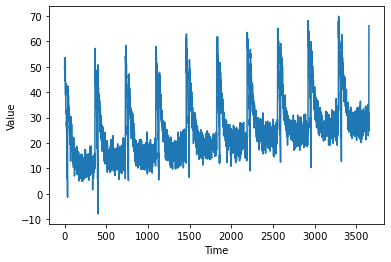

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 4 * np.pi),
                    2 / np.exp(10 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)
baseline = 10
amplitude = 40
slope = 0.005
noise_level = 3

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

# # # # # expected output
!gdown --id 1sDzcLKVZBQWeEYT101bEWCltlaFPjiIN
print("Expected:")
from IPython.display import display
from PIL import Image
path='./C4_W2_Assignment_Image.png'
display(Image.open(path))
# # # # #


Your output:


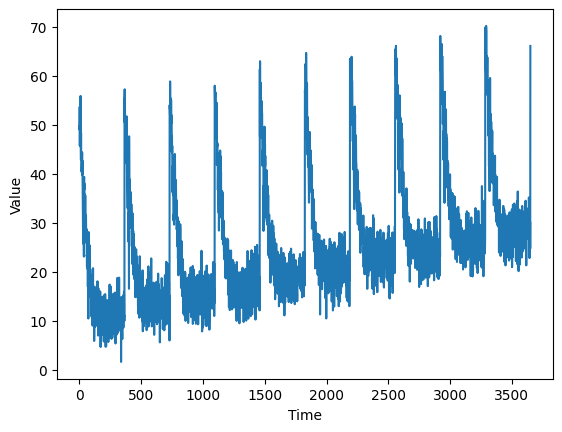

In [3]:
### your output
print("Your output:")
plot_series(time, series)

In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [5]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(50, input_shape = [window_size], activation = 'relu'),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=1)

Epoch 1/100
94/94 [==============================] - 3s 13ms/step - loss: 99.0033
Epoch 2/100
94/94 [==============================] - 1s 4ms/step - loss: 31.5076
Epoch 3/100
94/94 [==============================] - 0s 4ms/step - loss: 27.2558
Epoch 4/100
94/94 [==============================] - 0s 4ms/step - loss: 25.0776
Epoch 5/100
94/94 [==============================] - 0s 4ms/step - loss: 23.8646
Epoch 6/100
94/94 [==============================] - 1s 4ms/step - loss: 23.3378
Epoch 7/100
94/94 [==============================] - 0s 4ms/step - loss: 22.7704
Epoch 8/100
94/94 [==============================] - 0s 4ms/step - loss: 22.2977
Epoch 9/100
94/94 [==============================] - 1s 4ms/step - loss: 21.9568
Epoch 10/100
94/94 [==============================] - 1s 4ms/step - loss: 21.5787
Epoch 11/100
94/94 [==============================] - 1s 4ms/step - loss: 21.3745
Epoch 12/100
94/94 [==============================] - 0s 4ms/step - loss: 21.1749
Epoch 13/100
94/94 [====

1/1 [==============================] - 0s 32ms/step


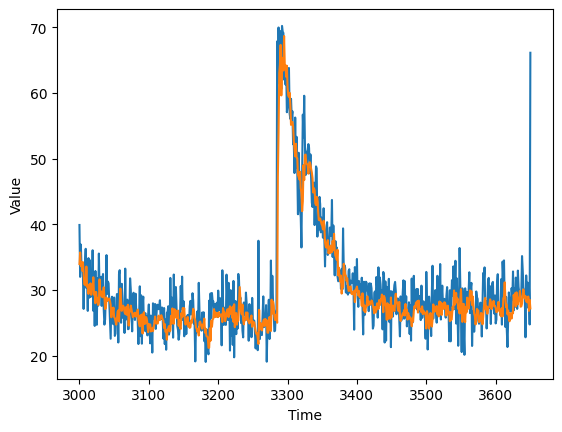

In [6]:
# Initialize a list
forecast = []

# Reduce the original series
forecast_series = series[split_time - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
  forecast.append(model.predict(forecast_series[time:time + window_size][np.newaxis]))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Plot the results
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [7]:
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()) #MAE has to be < 3

17.570925
2.8793898
